# Device

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

import time

from sklearn.utils import shuffle
from scipy.spatial.distance import pdist, squareform
from sklearn.utils.class_weight import compute_class_weight

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
import torch_geometric

# Dataloader definitions

In [2]:
#@title Dataloader definitions
class DotDict(dict):
    """Wrapper around in-built dict class to access members through the dot operation.
    """

    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


class SequentialTSPReader(object):
    """
    Iterator that reads TSP dataset files (Vinyals format) and yields SEQUENTIAL
    mini-batches for autoregressive next-city prediction.

    For each TSP graph of N nodes, generates N training samples:
        - coords: (N, 2)
        - dist_matrix: (N, N)
        - current_city: int
        - visited_mask: (N,)
        - target_next_city: int
    """

    def __init__(self, num_nodes, num_neighbors, batch_size, filepath):
        """
        Args:
            num_nodes: Number of nodes in TSP tours
            num_neighbors: (unused, kept for compatibility with original code)
            batch_size: Batch size
            filepath: Path to dataset file (.txt file)
        """
        self.num_nodes = num_nodes
        self.num_neighbors = num_neighbors
        self.batch_size = batch_size
        self.filepath = filepath
        self.filedata = shuffle(open(filepath, "r").readlines())
        self.max_iter = len(self.filedata)  # one graph per iteration

    def __iter__(self):
        """
        Yields batches of sequential samples.
        Each graph produces N samples, so batch_size refers to sequential samples.
        """
        batch = []

        for line in self.filedata:
            seq_examples = self.process_line(line)

            for ex in seq_examples:
                batch.append(ex)

                if len(batch) == self.batch_size:
                    yield self.collate(batch)
                    batch = []

        # Yield last incomplete batch
        if batch:
            yield self.collate(batch)

    def process_line(self, line):
        """
        Convert a single TSP instance into N sequential examples.
        """
        parts = line.split()

        # Extract coordinates
        coords = []
        for i in range(0, 2 * self.num_nodes, 2):
            coords.append([float(parts[i]), float(parts[i + 1])])
        coords = np.array(coords)

        # Compute distance matrix
        dist_matrix = squareform(pdist(coords, metric='euclidean'))

        # Extract tour (1-based indexing → convert to 0-based)
        idx_output = parts.index("output")
        tour = [int(x) - 1 for x in parts[idx_output + 1:]][:-1]  # remove repeated last node

        # Generate sequential examples
        examples = []
        visited = np.zeros(self.num_nodes, dtype=np.float32)

        for step in range(self.num_nodes - 2):
            current = tour[step]
            next_city = tour[step + 1]

            example = DotDict(
                coords=coords,
                dist_matrix=dist_matrix,
                current_city=current,
                visited_mask=visited.copy(),
                target_next_city=next_city
            )

            examples.append(example)
            visited[current] = 1

        return examples

    def collate(self, batch):
        """
        Convert list of DotDicts into a single DotDict batch.
        """
        return DotDict(
            coords=np.stack([b.coords for b in batch]),
            dist_matrix=np.stack([b.dist_matrix for b in batch]),
            current_city=np.array([b.current_city for b in batch]),
            visited_mask=np.stack([b.visited_mask for b in batch]),
            target_next_city=np.array([b.target_next_city for b in batch])
        )

## Exploring the dataset

In [3]:
num_nodes = 10
num_neighbors = -1    # when set to -1, it considers all the connections instead of k nearest neighbors
batch_size = num_nodes - 2
train_filepath = f"tsp-data/tsp{num_nodes}_train_concorde.txt"

dataset = SequentialTSPReader(num_nodes, num_neighbors, batch_size, train_filepath)

t = time.time()
batch = next(iter(dataset))  # Generate a batch of sequential TSP samples
print("Batch generation took: {:.3f} sec".format(time.time() - t))

print("coords:", batch.coords.shape)               # (B, N, 2)
print("dist_matrix:", batch.dist_matrix.shape)     # (B, N, N)
print("current_city:", batch.current_city.shape)   # (B,)
print("visited_mask:", batch.visited_mask.shape)   # (B, N)
print("target_next_city:", batch.target_next_city.shape)  # (B,)

Batch generation took: 0.001 sec
coords: (8, 10, 2)
dist_matrix: (8, 10, 10)
current_city: (8,)
visited_mask: (8, 10)
target_next_city: (8,)


In [4]:
def plot_tsp_sequential(ax, coords, dist_matrix, current_city, visited_mask, target_next_city, title="Sequential TSP Step"):
    """
    Visualizes a single sequential TSP example:
    - coords: (N,2)
    - dist_matrix: (N,N)
    - current_city: int
    - visited_mask: (N,)
    - target_next_city: int
    """

    N = len(coords)

    # Create graph with distances as weights
    G = nx.DiGraph()
    for i in range(N):
        for j in range(N):
            if i != j:
                G.add_edge(i, j, weight=dist_matrix[i][j])

    pos = {i: coords[i] for i in range(N)}

    # Draw all edges faintly
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

    # Draw nodes
    colors = []
    for i in range(N):
        if i == current_city:
            colors.append("green")     # current city
        elif i == target_next_city:
            colors.append("red")       # next correct city
        elif visited_mask[i] == 1:
            colors.append("blue")      # visited
        else:
            colors.append("gray")      # unvisited

    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=80)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8)

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


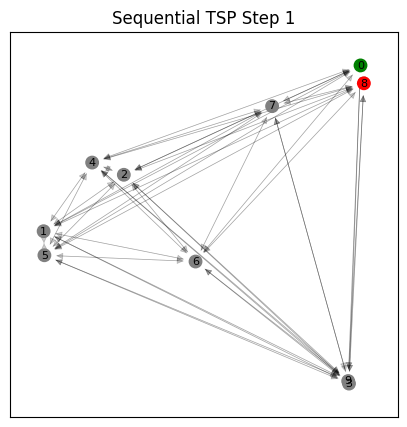


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


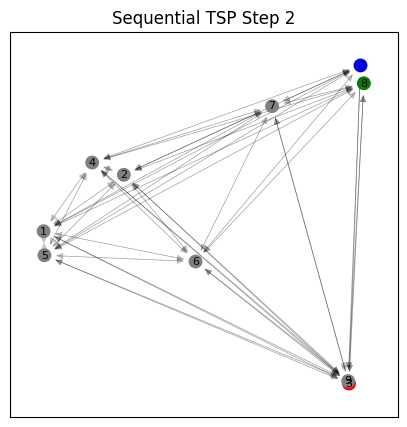


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


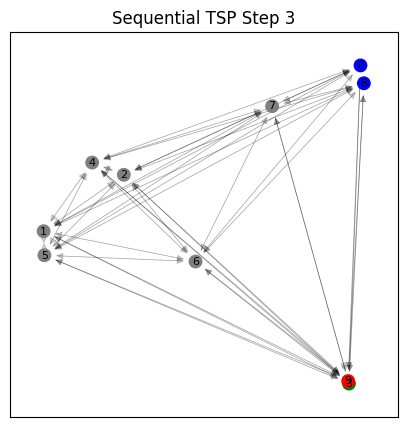


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


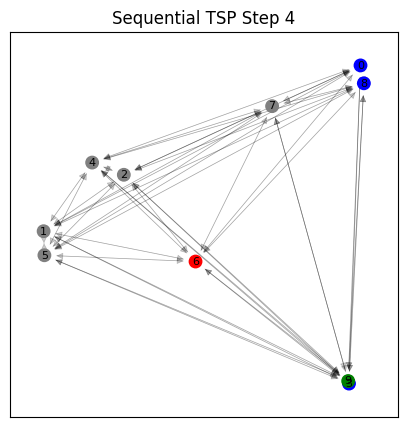


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


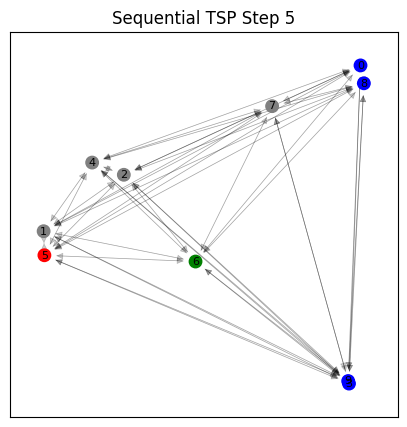


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


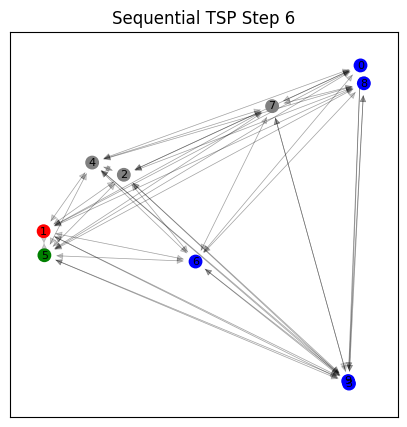


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


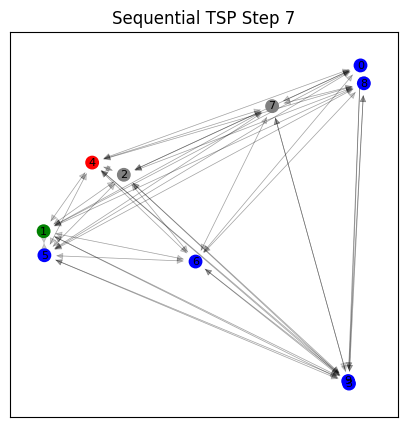


--- SOURCE LINE FOR THIS GRAPH ---
0.9420950733132719 0.9936668024485222 0.05327404047055484 0.5482637435794039 0.27822702293745505 0.6998479723040049 0.9097998440419399 0.1389145729081368 0.18937332221224046 0.7326459519013193 0.05545164912216771 0.4836722861917171 0.47935333173686456 0.46681474196144346 0.6941369314590133 0.8841811819181126 0.9515295636943694 0.9455833433380358 0.9074985437044392 0.14578668475735201 output 1 9 4 10 7 6 2 5 3 8 1


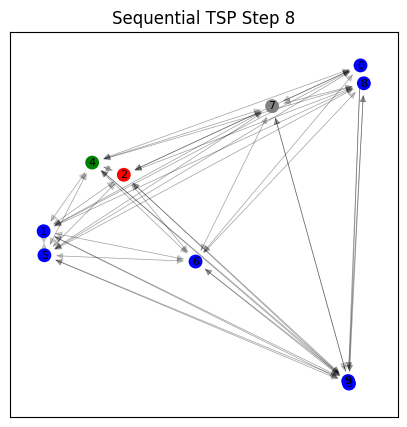

In [5]:
for idx in range(batch_size):
    line_index = idx // (num_nodes - 2)
    print("\n--- SOURCE LINE FOR THIS GRAPH ---")
    print(dataset.filedata[line_index].strip())

    f = plt.figure(figsize=(5, 5))
    ax = f.add_subplot(111)

    plot_tsp_sequential(
        ax,
        batch.coords[idx],
        batch.dist_matrix[idx],
        batch.current_city[idx],
        batch.visited_mask[idx],
        batch.target_next_city[idx],
        title=f"Sequential TSP Step {(idx % (num_nodes - 2)) + 1}"
    )
    plt.show()

# Model definition

## MLP layer

In [6]:
#@title MLP layer
class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction.
    """

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        self.L = L
        U = []
        for layer in range(self.L - 1):
            U.append(nn.Linear(hidden_dim, hidden_dim, True))
        self.U = nn.ModuleList(U)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, hidden_dim)

        Returns:
            y: Output predictions (batch_size, output_dim)
        """
        Ux = x
        for U_i in self.U:
            Ux = U_i(Ux)  # B x H
            Ux = F.relu(Ux)  # B x H
        y = self.V(Ux)  # B x O
        return y

## Node Embedding Layer

In [7]:
#@title Node Embedding Layer
class NodeEmbedding(nn.Module):
    """
    Embedding inicial dels nodes a partir de:
      - coordenades (x, y)
      - visited_mask (0/1)
    """

    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, hidden_dim),   # x, y, visited
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, coords, visited_mask):
        """
        coords: (B, N, 2)
        visited_mask: (B, N)
        """
        x = torch.cat([coords, visited_mask.unsqueeze(-1)], dim=-1)  # (B, N, 3)
        return self.mlp(x)  # (B, N, hidden_dim)

## Simple GCN Encoder

In [ ]:
#@title Simple GCN Encoder
class SimpleGCNEncoder(nn.Module):
    """
    Encoder GCN lleuger que combina embeddings de nodes utilitzant la distància.
    """

    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, node_emb, dist_matrix):
        """
        node_emb: (B, N, hidden_dim)
        dist_matrix: (B, N, N)
        """
        # Convertim distàncies en pesos (com una soft adjacency)
        weights = torch.exp(-dist_matrix)  # (B, N, N)

        # Message passing: agreguem info dels veïns
        agg = torch.bmm(weights, node_emb)  # (B, N, hidden_dim)

        # Residual + projecció
        out = self.W(agg + node_emb)

        return F.relu(out)


## Transformer Encoder

In [ ]:
#@title Transformer Encoder
class TransformerEncoder(nn.Module):
    """
    Encoder potent basat en Transformer (self-attention).
    """

    def __init__(self, hidden_dim, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, node_emb, dist_matrix=None):
        """
        node_emb: (B, N, hidden_dim)
        dist_matrix: no s'utilitza directament (el transformer aprèn relacions)
        """
        return self.encoder(node_emb)
